In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mne
import matplotlib.pyplot as plt
import seaborn as sns
from mne_bids import BIDSPath, read_raw_bids

In [3]:
bids_root = "./nm000104"
subject = "01438774"
session = "1625258895"
bpath = BIDSPath(
    root=bids_root,
    subject=subject,
    session=session,
    task="typing",
    extension="edf",
    datatype="emg",
    suffix="emg"
)
bpath.fpath

PosixPath('nm000104/sub-01438774/ses-1625258895/emg/sub-01438774_ses-1625258895_task-typing_emg.edf')

In [4]:
raw = read_raw_bids(bpath)
raw

/var/folders/hs/jr1l53bx1m1gmsqm294qcpy40000gn/T/ipykernel_27624/214897811.py:1: RuntimeWarning: Unable to map the following column(s) to to MNE:
handedness: n/a
  raw = read_raw_bids(bpath)


<RawEDF | sub-01438774_ses-1625258895_task-typing_emg.edf, 32 x 2058000 (1029.0 s), ~28 KiB, data not loaded>

In [5]:
raw.annotations

<Annotations | 4749 segments: keystroke (4596), prompt (153)>

In [6]:
annot_df = raw.annotations.to_data_frame()
annot_df.head()

,onset,duration,description,key,prompt_text
0,2025-09-30 22:07:57.272500,19.518,prompt,n/a,the quick brown fox jumps over a lazy dog\n
1,2025-09-30 22:07:59.757500,0.028,keystroke,t,n/a
2,2025-09-30 22:07:59.905500,0.075,keystroke,h,n/a
3,2025-09-30 22:07:59.995500,0.090,keystroke,e,n/a
4,2025-09-30 22:08:00.505499,0.090,keystroke,Key.space,n/a


/var/folders/hs/jr1l53bx1m1gmsqm294qcpy40000gn/T/ipykernel_27624/3968951373.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


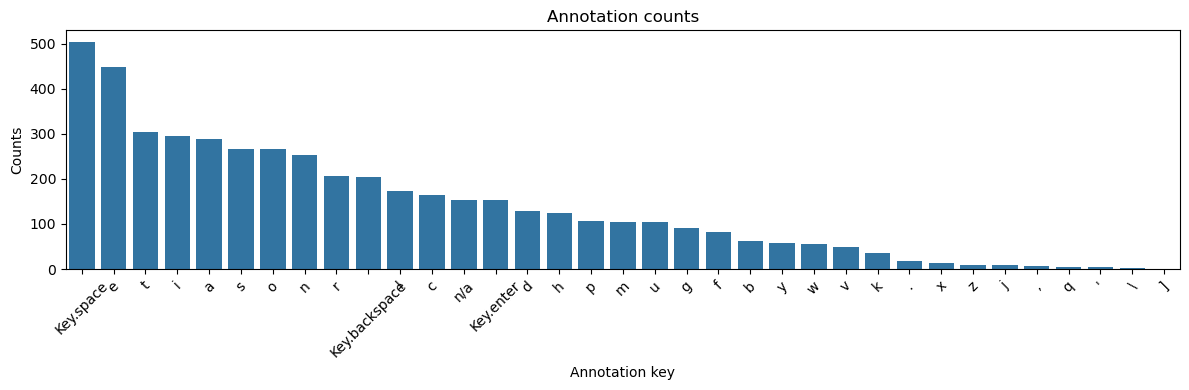

In [7]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.barplot(x=annot_df.key.value_counts().index, y=annot_df.key.value_counts().values, ax=ax)
ax.set_title("Annotation counts")
ax.set_ylabel("Counts")
ax.set_xlabel("Annotation key")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()

In [8]:
annot_df["description"] = annot_df.apply(
    lambda row: f"{row['description']}/{row['key']}" if row['key'] != 'n/a' else row['description'],
    axis=1
)
annot_df = annot_df.drop(columns=["key"])
annot_df.head()

,onset,duration,description,prompt_text
0,2025-09-30 22:07:57.272500,19.518,prompt,the quick brown fox jumps over a lazy dog\n
1,2025-09-30 22:07:59.757500,0.028,keystroke/t,n/a
2,2025-09-30 22:07:59.905500,0.075,keystroke/h,n/a
3,2025-09-30 22:07:59.995500,0.090,keystroke/e,n/a
4,2025-09-30 22:08:00.505499,0.090,keystroke/Key.space,n/a


In [9]:
raw.annotations.description = annot_df["description"].values
events, event_id = mne.events_from_annotations(raw)

/var/folders/hs/jr1l53bx1m1gmsqm294qcpy40000gn/T/ipykernel_27624/4080106566.py:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  _ = mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info["sfreq"])


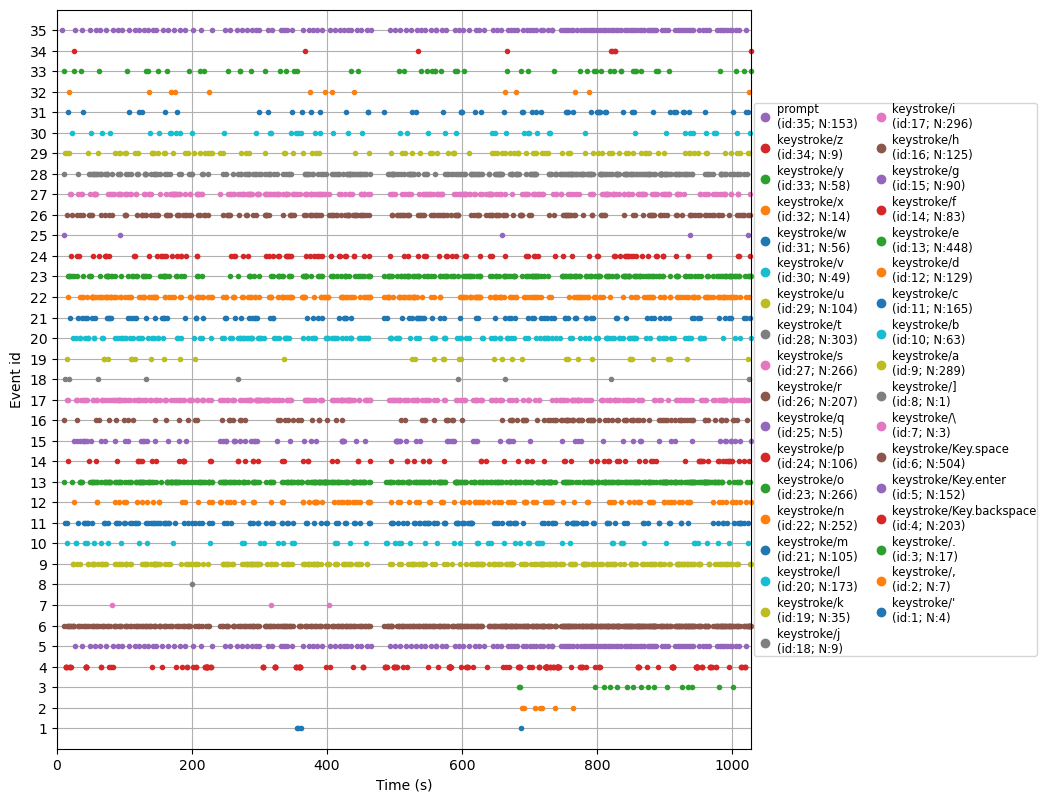

In [10]:
_ = mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info["sfreq"])

In [11]:
raw.load_data()
picks = mne.pick_types(raw.info, emg=True, exclude="bads")
raw.filter(40., None, picks=picks)  # check that high-pass is not set properly in the measurement info

<RawEDF | sub-01438774_ses-1625258895_task-typing_emg.edf, 32 x 2058000 (1029.0 s), ~502.5 MiB, data loaded>

In [12]:
picks

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

/Users/agramfort/work/src/mne-python/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


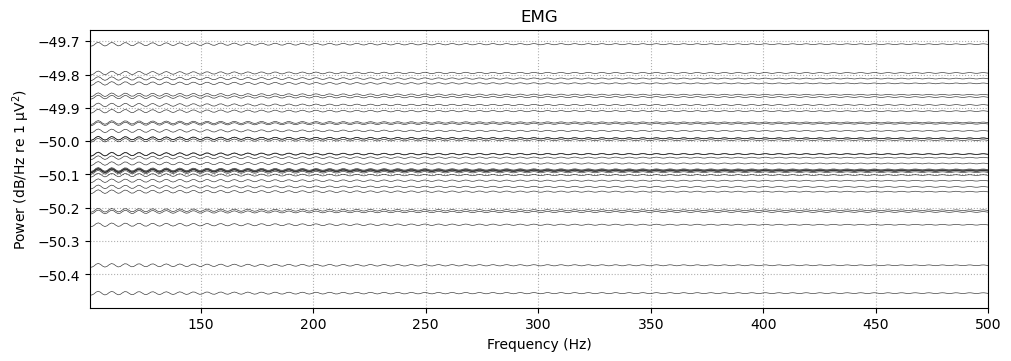

In [13]:
_ = raw.compute_psd(picks=picks, fmin=100, fmax=500).plot(picks=picks, spatial_colors=False)

In [14]:
# mne.viz.set_browser_backend("qt")
# _ = raw.plot(scalings={'emg': 1e6}, start=40, duration=5, n_channels=32)

In [15]:
epochs = mne.Epochs(
    raw,
    events=events,
    event_id=event_id,
    tmin=-0.2,
    tmax=0.5,
    baseline=(None, 0),
    preload=False,
    picks=picks,
)

In [16]:
epochs["a"]

<Epochs | 289 events (good & bad), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~28 KiB, data not loaded,
 'keystroke/a': 289>

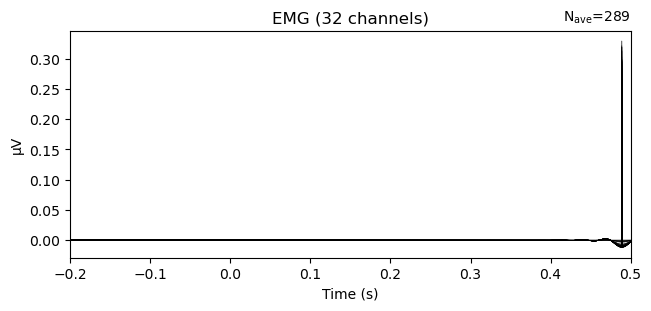

In [17]:
_ = epochs["a"].average(picks=picks).plot(spatial_colors=False)

In [18]:
data = raw.get_data(picks=picks)
data.shape

(32, 2058000)

In [19]:
import numpy as np
np.ptp(data, axis=1)

array([9.50028651e-05, 9.58475379e-05, 9.50199869e-05, 9.75625662e-05,
       9.60501453e-05, 9.75796880e-05, 9.91720104e-05, 1.04068830e-04,
       9.95401280e-05, 9.92433510e-05, 1.16884457e-04, 1.33929156e-04,
       1.26133054e-04, 1.10931797e-04, 9.77965634e-05, 9.45748214e-05,
       9.65723586e-05, 9.67749659e-05, 9.57761973e-05, 9.55250784e-05,
       9.84928478e-05, 1.10292585e-04, 1.16256660e-04, 1.04936332e-04,
       9.97199063e-05, 1.04864991e-04, 1.10615044e-04, 1.10677824e-04,
       1.03863369e-04, 9.98797093e-05, 9.81903636e-05, 1.00122267e-04])

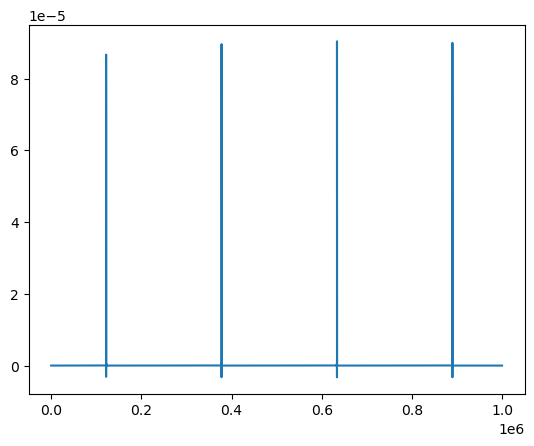

In [20]:
plt.plot(data[:1, 1_000_000:].T[:1_000_000]);